# **Projekt 2 - Gabriela Matuszewska, Mateusz Wojtulewicz**
gabimatuszewska3@gmail.com <br>
mateusz.wojtulewicz@gmail.com

# Zadanie 1 - przygotowanie potrzebnych funkcji oraz importy

In [1]:
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
def showOpencvImage(image, isGray=False):
    fig = plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap = 'gray')
    plt.show()

def openCVHOG(im):
    winSize = (20,20)
    blockSize = (10,10)
    blockStride = (5,5)
    cellSize = (10,10)
    nbins = 9
    derivAperture = 1
    winSigma = -1.
    histogramNormType = 0
    L2HysThreshold = 0.2
    gammaCorrection = 1
    nlevels = 64
    signedGradients = True
    
    # histogram of oriented gradiens
    hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                            histogramNormType,L2HysThreshold,gammaCorrection,nlevels, signedGradients)
    descriptor = np.ravel(hog.compute(im))
    
    return descriptor

In [3]:
## [deskew] -> roating a scanned image to compensate for skewing
SZ=28
affine_flags = cv2.WARP_INVERSE_MAP|cv2.INTER_LINEAR

def deskew(img):
    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    img = cv2.warpAffine(img,M,(SZ, SZ),flags=affine_flags)
    return img
## [deskew]

## Załadowanie danych

In [4]:
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [5]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

# Zadanie 2

## Trening klasyfikatorów dla danych z funkcją Deskew oraz HOG
Wraz z wyborem parametrów modelu przy użyciu gridSearchCV.

In [6]:
# uzycie funkcji deskew

train_deskewed = [deskew(im) for im in train_images]
train_deskewed = np.asarray(train_deskewed)

In [7]:
# hog

hogdata = [openCVHOG(im) for im in train_deskewed]
imData = np.float32(hogdata).reshape(-1,81)
print(imData.shape)

(60000, 81)


## SVM

In [8]:
from sklearn import svm

parameters = {'kernel':('linear','rbf'), 'C':[1,10], 'gamma':('scale', 'auto')}

svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=5, verbose=3)
clf.fit(imData[:6000], train_labels[:6000])

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END ................C=1, gamma=scale, kernel=linear; total time=   0.2s
[CV 2/5] END ................C=1, gamma=scale, kernel=linear; total time=   0.2s
[CV 3/5] END ................C=1, gamma=scale, kernel=linear; total time=   0.2s
[CV 4/5] END ................C=1, gamma=scale, kernel=linear; total time=   0.2s
[CV 5/5] END ................C=1, gamma=scale, kernel=linear; total time=   0.2s
[CV 1/5] END ...................C=1, gamma=scale, kernel=rbf; total time=   0.3s
[CV 2/5] END ...................C=1, gamma=scale, kernel=rbf; total time=   0.4s
[CV 3/5] END ...................C=1, gamma=scale, kernel=rbf; total time=   0.3s
[CV 4/5] END ...................C=1, gamma=scale, kernel=rbf; total time=   0.3s
[CV 5/5] END ...................C=1, gamma=scale, kernel=rbf; total time=   0.3s
[CV 1/5] END .................C=1, gamma=auto, kernel=linear; total time=   0.2s
[CV 2/5] END .................C=1, gamma=auto, ke

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 10], 'gamma': ('scale', 'auto'),
                         'kernel': ('linear', 'rbf')},
             verbose=3)

In [9]:
clf.best_score_, clf.best_params_

(0.9706666666666667, {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'})

96.65


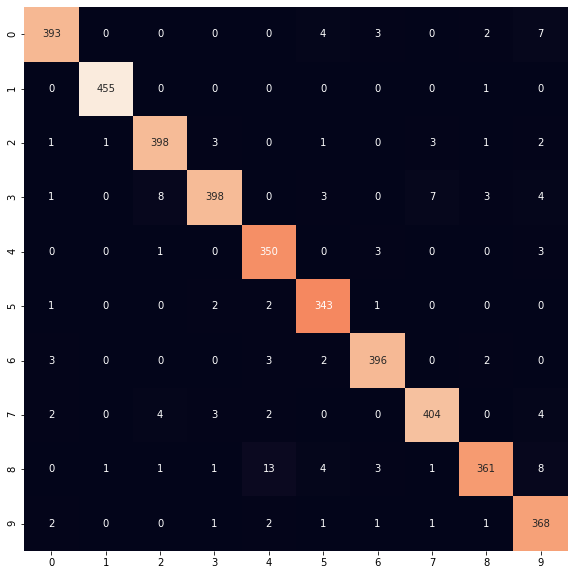

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       409
           1       1.00      1.00      1.00       456
           2       0.97      0.97      0.97       410
           3       0.98      0.94      0.96       424
           4       0.94      0.98      0.96       357
           5       0.96      0.98      0.97       349
           6       0.97      0.98      0.97       406
           7       0.97      0.96      0.97       419
           8       0.97      0.92      0.95       393
           9       0.93      0.98      0.95       377

    accuracy                           0.97      4000
   macro avg       0.97      0.97      0.97      4000
weighted avg       0.97      0.97      0.97      4000



In [10]:
model = svm.SVC(**clf.best_params_)
model.fit(imData[:6000], train_labels[:6000])
pred_labels = model.predict(imData[6000:10000])
real_labels = train_labels[6000:10000]

mask = pred_labels == real_labels
correct = np.count_nonzero(mask)
print(correct*100.0/pred_labels.size)

cm = confusion_matrix(real_labels, pred_labels)
fig = plt.figure(figsize = (10,10))
sns.heatmap(cm, annot = True, square = True, fmt = 'd', cbar = False)
plt.show()
print(classification_report(real_labels, pred_labels))

## Random Forest Classifier ##

In [28]:
from sklearn.ensemble import RandomForestClassifier

params = {'max_features': [1,30,60],
          'max_depth': [15,20,25], 
          'criterion': ["entropy","gini"]}
model = RandomForestClassifier()

grid=GridSearchCV(estimator=model, param_grid=params, cv=5, verbose=4)
grid.fit(imData[:6000], train_labels[:6000])


Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END criterion=entropy, max_depth=15, max_features=1; total time=   0.9s
[CV 2/5] END criterion=entropy, max_depth=15, max_features=1; total time=   0.9s
[CV 3/5] END criterion=entropy, max_depth=15, max_features=1; total time=   0.8s
[CV 4/5] END criterion=entropy, max_depth=15, max_features=1; total time=   1.0s
[CV 5/5] END criterion=entropy, max_depth=15, max_features=1; total time=   0.9s
[CV 1/5] END criterion=entropy, max_depth=15, max_features=30; total time=  16.4s
[CV 2/5] END criterion=entropy, max_depth=15, max_features=30; total time=  16.8s
[CV 3/5] END criterion=entropy, max_depth=15, max_features=30; total time=  16.9s
[CV 4/5] END criterion=entropy, max_depth=15, max_features=30; total time=  16.6s
[CV 5/5] END criterion=entropy, max_depth=15, max_features=30; total time=  11.0s
[CV 1/5] END criterion=entropy, max_depth=15, max_features=60; total time=  32.9s
[CV 2/5] END criterion=entropy, max_depth=

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [15, 20, 25],
                         'max_features': [1, 30, 60]},
             verbose=4)

In [29]:
grid.best_score_, grid.best_params_

(0.9371666666666666,
 {'criterion': 'entropy', 'max_depth': 25, 'max_features': 30})

92.7


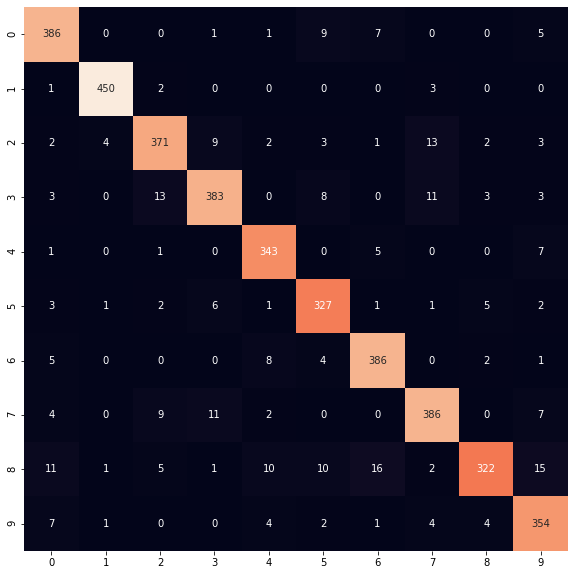

              precision    recall  f1-score   support

           0       0.91      0.94      0.93       409
           1       0.98      0.99      0.99       456
           2       0.92      0.90      0.91       410
           3       0.93      0.90      0.92       424
           4       0.92      0.96      0.94       357
           5       0.90      0.94      0.92       349
           6       0.93      0.95      0.94       406
           7       0.92      0.92      0.92       419
           8       0.95      0.82      0.88       393
           9       0.89      0.94      0.91       377

    accuracy                           0.93      4000
   macro avg       0.93      0.93      0.93      4000
weighted avg       0.93      0.93      0.93      4000



In [30]:
rfc = RandomForestClassifier(**grid.best_params_)
rfc.fit(imData[:6000], train_labels[:6000])

pred_labels = rfc.predict(imData[6000:10000])

mask = pred_labels==train_labels[6000:10000]
correct = np.count_nonzero(mask)
print(correct*100.0/pred_labels.size)

cm = confusion_matrix(train_labels[6000:10000], pred_labels)
fig = plt.figure(figsize = (10,10))
sns.heatmap(cm, annot=True, square=True, fmt='d', cbar=False)
plt.show()
print(classification_report(train_labels[6000:10000], pred_labels))

## Sieci:

In [31]:
from keras import models
from keras import layers

network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(81,)))
network.add(layers.Dense(10, activation='softmax'))


In [32]:
network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [33]:
from keras.utils import to_categorical

encoded_train_labels = to_categorical(train_labels)
encoded_test_labels = to_categorical(test_labels)

# encoded_test_labels

In [34]:
network.fit(imData[:6000], encoded_train_labels[:6000], epochs=5, batch_size=128)

Epoch 1/5
47/47 [==============================] - 0s 2ms/step - loss: 1.6690 - accuracy: 0.6240
Epoch 2/5
47/47 [==============================] - 0s 2ms/step - loss: 0.6440 - accuracy: 0.8688
Epoch 3/5
47/47 [==============================] - 0s 2ms/step - loss: 0.4101 - accuracy: 0.9013
Epoch 4/5
47/47 [==============================] - 0s 2ms/step - loss: 0.3029 - accuracy: 0.9210
Epoch 5/5
47/47 [==============================] - 0s 2ms/step - loss: 0.2662 - accuracy: 0.9235


In [35]:
test_loss, test_acc = network.evaluate(imData[6000:10000], encoded_train_labels[6000:10000])
print('test_acc:', test_acc)

125/125 [==============================] - 0s 776us/step - loss: 0.2857 - accuracy: 0.9150
test_acc: 0.9150000214576721


In [36]:
pred_probabilities = network.predict(imData[6000:10000])
print(pred_probabilities[0:1])

[[1.2230679e-03 2.2876113e-05 2.4311954e-05 5.9944332e-06 5.4416331e-03
  1.2632505e-03 9.8987573e-01 1.6299275e-06 1.6860695e-03 4.5541636e-04]]


In [39]:
pred_labels = np.argmax(pred_probabilities,-1)

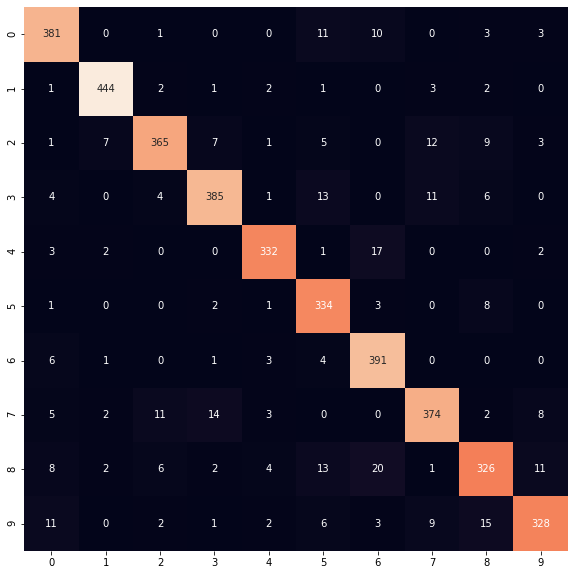

              precision    recall  f1-score   support

           0       0.90      0.93      0.92       409
           1       0.97      0.97      0.97       456
           2       0.93      0.89      0.91       410
           3       0.93      0.91      0.92       424
           4       0.95      0.93      0.94       357
           5       0.86      0.96      0.91       349
           6       0.88      0.96      0.92       406
           7       0.91      0.89      0.90       419
           8       0.88      0.83      0.85       393
           9       0.92      0.87      0.90       377

    accuracy                           0.92      4000
   macro avg       0.91      0.91      0.91      4000
weighted avg       0.92      0.92      0.91      4000



In [40]:
cm = confusion_matrix(train_labels[6000:10000], pred_labels)
fig = plt.figure(figsize = (10,10))
sns.heatmap(cm, annot = True, square = True, fmt = 'd', cbar = False)
plt.show()

print(classification_report(train_labels[6000:10000], pred_labels))

# Trening klasyfikatorów dla danych bez funkcji Deskew
Wraz z wyborem parametrów modelu przy użyciu gridSearchCV.

In [41]:
hogdata = [openCVHOG(im) for im in train_images]
imData = np.float32(hogdata).reshape(-1,81)
print(imData.shape)

(60000, 81)


## SVM

In [42]:
from sklearn import svm

parameters = {'kernel': ('linear','rbf'), 
              'C': [1,10], 
              'gamma': ('scale', 'auto')}

svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=5, verbose=3)

clf.fit(imData[:6000], train_labels[:6000])

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END ................C=1, gamma=scale, kernel=linear; total time=   0.2s
[CV 2/5] END ................C=1, gamma=scale, kernel=linear; total time=   0.2s
[CV 3/5] END ................C=1, gamma=scale, kernel=linear; total time=   0.2s
[CV 4/5] END ................C=1, gamma=scale, kernel=linear; total time=   0.2s
[CV 5/5] END ................C=1, gamma=scale, kernel=linear; total time=   0.2s
[CV 1/5] END ...................C=1, gamma=scale, kernel=rbf; total time=   0.4s
[CV 2/5] END ...................C=1, gamma=scale, kernel=rbf; total time=   0.4s
[CV 3/5] END ...................C=1, gamma=scale, kernel=rbf; total time=   0.4s
[CV 4/5] END ...................C=1, gamma=scale, kernel=rbf; total time=   0.4s
[CV 5/5] END ...................C=1, gamma=scale, kernel=rbf; total time=   0.4s
[CV 1/5] END .................C=1, gamma=auto, kernel=linear; total time=   0.2s
[CV 2/5] END .................C=1, gamma=auto, ke

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 10], 'gamma': ('scale', 'auto'),
                         'kernel': ('linear', 'rbf')},
             verbose=3)

In [43]:
clf.best_score_, clf.best_params_

(0.9594999999999999, {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'})

95.35


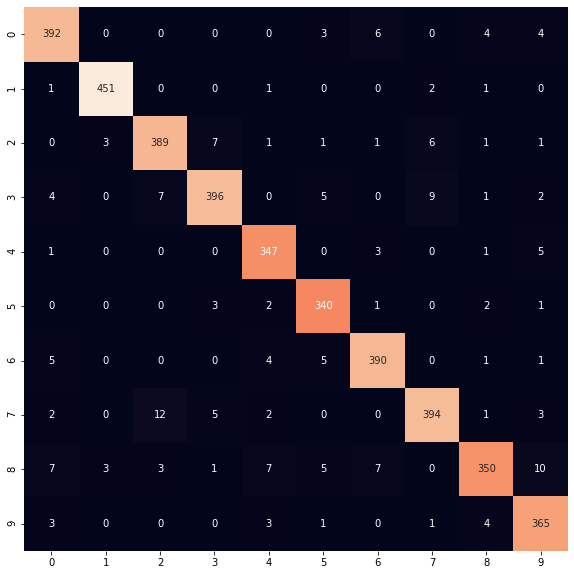

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       409
           1       0.99      0.99      0.99       456
           2       0.95      0.95      0.95       410
           3       0.96      0.93      0.95       424
           4       0.95      0.97      0.96       357
           5       0.94      0.97      0.96       349
           6       0.96      0.96      0.96       406
           7       0.96      0.94      0.95       419
           8       0.96      0.89      0.92       393
           9       0.93      0.97      0.95       377

    accuracy                           0.95      4000
   macro avg       0.95      0.95      0.95      4000
weighted avg       0.95      0.95      0.95      4000



In [44]:
model = svm.SVC(**clf.best_params_)
model.fit(imData[:6000], train_labels[:6000])
pred_labels = model.predict(imData[6000:10000])
real_labels = train_labels[6000:10000]

mask = pred_labels == real_labels
correct = np.count_nonzero(mask)
print(correct*100.0/pred_labels.size)

cm = confusion_matrix(real_labels, pred_labels)
fig = plt.figure(figsize = (10,10))
sns.heatmap(cm, annot = True, square = True, fmt = 'd', cbar = False)
plt.show()

print(classification_report(real_labels, pred_labels))

## Random Forest Classifier ##

In [45]:
params = {'max_features': [1,30,60],
          'max_depth': [15,20,25], 
          'criterion': ["entropy","gini"]}
model = RandomForestClassifier()

grid=GridSearchCV(estimator=model, param_grid=params, cv=5, verbose = 4)
grid.fit(imData[:6000], train_labels[:6000])


Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END criterion=entropy, max_depth=15, max_features=1; total time=   0.9s
[CV 2/5] END criterion=entropy, max_depth=15, max_features=1; total time=   0.9s
[CV 3/5] END criterion=entropy, max_depth=15, max_features=1; total time=   0.9s
[CV 4/5] END criterion=entropy, max_depth=15, max_features=1; total time=   0.9s
[CV 5/5] END criterion=entropy, max_depth=15, max_features=1; total time=   0.9s
[CV 1/5] END criterion=entropy, max_depth=15, max_features=30; total time=  16.9s
[CV 2/5] END criterion=entropy, max_depth=15, max_features=30; total time=  16.5s
[CV 3/5] END criterion=entropy, max_depth=15, max_features=30; total time=  16.4s
[CV 4/5] END criterion=entropy, max_depth=15, max_features=30; total time=  16.2s
[CV 5/5] END criterion=entropy, max_depth=15, max_features=30; total time=  16.5s
[CV 1/5] END criterion=entropy, max_depth=15, max_features=60; total time=  32.6s
[CV 2/5] END criterion=entropy, max_depth=

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [15, 20, 25],
                         'max_features': [1, 30, 60]},
             verbose=4)

In [46]:
grid.best_score_, grid.best_params_

(0.9369999999999999,
 {'criterion': 'gini', 'max_depth': 20, 'max_features': 30})

92.775


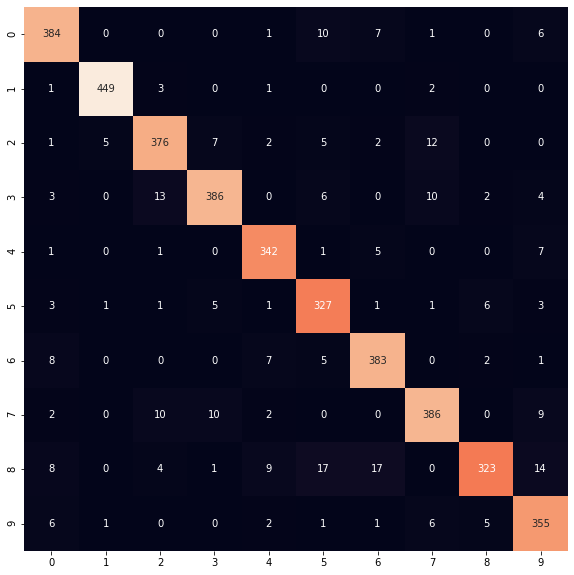

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       409
           1       0.98      0.98      0.98       456
           2       0.92      0.92      0.92       410
           3       0.94      0.91      0.93       424
           4       0.93      0.96      0.94       357
           5       0.88      0.94      0.91       349
           6       0.92      0.94      0.93       406
           7       0.92      0.92      0.92       419
           8       0.96      0.82      0.88       393
           9       0.89      0.94      0.91       377

    accuracy                           0.93      4000
   macro avg       0.93      0.93      0.93      4000
weighted avg       0.93      0.93      0.93      4000



In [47]:
rfc =  RandomForestClassifier(**grid.best_params_)
rfc = rfc.fit(imData[:6000],train_labels[:6000])

pred_labels = rfc.predict(imData[6000:10000])

mask = pred_labels==train_labels[6000:10000]
correct = np.count_nonzero(mask)
print(correct*100.0/pred_labels.size)

cm = confusion_matrix(train_labels[6000:10000], pred_labels)
fig = plt.figure(figsize = (10,10))
sns.heatmap(cm, annot = True, square = True, fmt = 'd', cbar = False)
plt.show()

print(classification_report(train_labels[6000:10000], pred_labels))

## Sieci ##

In [48]:
network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(81,)))
network.add(layers.Dense(10, activation='softmax'))

In [49]:
network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [50]:
encoded_train_labels = to_categorical(train_labels)
encoded_test_labels = to_categorical(test_labels)

# encoded_test_labels

In [51]:
network.fit(imData[:6000], encoded_train_labels[:6000], epochs=5, batch_size=128)

Epoch 1/5
47/47 [==============================] - 0s 2ms/step - loss: 1.7137 - accuracy: 0.5619
Epoch 2/5
47/47 [==============================] - 0s 2ms/step - loss: 0.6651 - accuracy: 0.8661
Epoch 3/5
47/47 [==============================] - 0s 2ms/step - loss: 0.4144 - accuracy: 0.9008
Epoch 4/5
47/47 [==============================] - 0s 2ms/step - loss: 0.3113 - accuracy: 0.9201
Epoch 5/5
47/47 [==============================] - 0s 2ms/step - loss: 0.2570 - accuracy: 0.9277


In [52]:
test_loss, test_acc = network.evaluate(imData[6000:10000], encoded_train_labels[6000:10000])
print('test_acc:', test_acc)

125/125 [==============================] - 0s 795us/step - loss: 0.2819 - accuracy: 0.9178
test_acc: 0.9177500009536743


In [53]:
pred_probabilities = network.predict(imData[6000:10000])
print(pred_probabilities[0:1])

[[4.3083522e-03 5.7715053e-05 8.6924098e-05 2.2421076e-05 2.9130954e-02
  1.4103221e-03 9.6038187e-01 8.3480918e-06 3.3271925e-03 1.2659129e-03]]


In [54]:
pred_labels = np.argmax(pred_probabilities,-1)

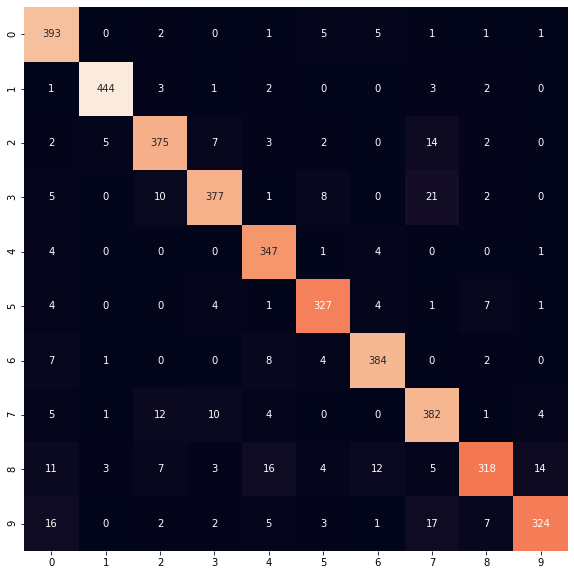

              precision    recall  f1-score   support

           0       0.88      0.96      0.92       409
           1       0.98      0.97      0.98       456
           2       0.91      0.91      0.91       410
           3       0.93      0.89      0.91       424
           4       0.89      0.97      0.93       357
           5       0.92      0.94      0.93       349
           6       0.94      0.95      0.94       406
           7       0.86      0.91      0.89       419
           8       0.93      0.81      0.87       393
           9       0.94      0.86      0.90       377

    accuracy                           0.92      4000
   macro avg       0.92      0.92      0.92      4000
weighted avg       0.92      0.92      0.92      4000



In [55]:
cm = confusion_matrix(train_labels[6000:10000], pred_labels)

fig = plt.figure(figsize = (10,10))
sns.heatmap(cm, annot = True, square = True, fmt = 'd', cbar = False)
plt.show()
print(classification_report(train_labels[6000:10000], pred_labels))

# Zadanie 3

## Trening klasyfikatorów dla danych bez HOG
Wraz z wyborem parametrów modelu przy użyciu gridSearchCV.

In [56]:
train_deskewed = [deskew(im) for im in train_images]
train_deskewed = np.asarray(train_deskewed)

In [57]:
train_in = train_deskewed.reshape(-1,28*28)
train_lb = train_labels.reshape(-1,)
train_in.shape

(60000, 784)

## SVM

In [58]:
parameters = {'kernel': ('linear','rbf'), 
              'C': [1,10], 
              'gamma': ('scale', 'auto')}

svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=5, verbose=3)

clf.fit(train_in[:6000], train_lb[:6000])

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END ................C=1, gamma=scale, kernel=linear; total time=   2.2s
[CV 2/5] END ................C=1, gamma=scale, kernel=linear; total time=   2.2s
[CV 3/5] END ................C=1, gamma=scale, kernel=linear; total time=   2.2s
[CV 4/5] END ................C=1, gamma=scale, kernel=linear; total time=   2.2s
[CV 5/5] END ................C=1, gamma=scale, kernel=linear; total time=   2.2s
[CV 1/5] END ...................C=1, gamma=scale, kernel=rbf; total time=   4.1s
[CV 2/5] END ...................C=1, gamma=scale, kernel=rbf; total time=   4.2s
[CV 3/5] END ...................C=1, gamma=scale, kernel=rbf; total time=   4.2s
[CV 4/5] END ...................C=1, gamma=scale, kernel=rbf; total time=   4.2s
[CV 5/5] END ...................C=1, gamma=scale, kernel=rbf; total time=   4.2s
[CV 1/5] END .................C=1, gamma=auto, kernel=linear; total time=   2.1s
[CV 2/5] END .................C=1, gamma=auto, ke

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 10], 'gamma': ('scale', 'auto'),
                         'kernel': ('linear', 'rbf')},
             verbose=3)

In [59]:
clf.best_score_, clf.best_params_

(0.9671666666666667, {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'})

96.625


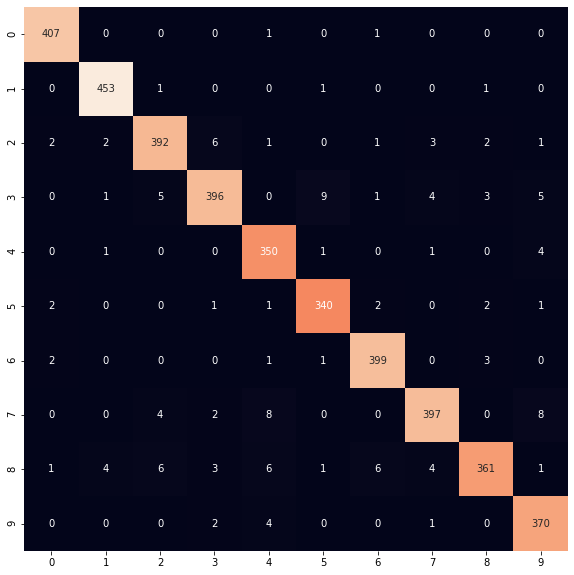

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       409
           1       0.98      0.99      0.99       456
           2       0.96      0.96      0.96       410
           3       0.97      0.93      0.95       424
           4       0.94      0.98      0.96       357
           5       0.96      0.97      0.97       349
           6       0.97      0.98      0.98       406
           7       0.97      0.95      0.96       419
           8       0.97      0.92      0.94       393
           9       0.95      0.98      0.96       377

    accuracy                           0.97      4000
   macro avg       0.97      0.97      0.97      4000
weighted avg       0.97      0.97      0.97      4000



In [60]:
model = svm.SVC(**clf.best_params_)
model.fit(train_in[:6000], train_lb[:6000])
pred_labels = model.predict(train_in[6000:10000].reshape(-1, 28*28))
real_labels = train_lb[6000:10000]

mask = pred_labels == real_labels
correct = np.count_nonzero(mask)
print(correct*100.0/pred_labels.size)

cm = confusion_matrix(real_labels, pred_labels)
fig = plt.figure(figsize = (10,10))
sns.heatmap(cm, annot = True, square = True, fmt = 'd', cbar = False)
plt.show()
print(classification_report(real_labels, pred_labels))

## Random Forest Classifier ##

In [61]:
params = {'max_features': [1,30,60],
          'max_depth': [15,20,25], 
          'criterion': ["entropy","gini"]}
model = RandomForestClassifier()

grid=GridSearchCV(estimator=model, param_grid=params, cv=5, verbose = 4)
grid.fit(train_in[:6000],train_lb[:6000])


Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END criterion=entropy, max_depth=15, max_features=1; total time=   0.5s
[CV 2/5] END criterion=entropy, max_depth=15, max_features=1; total time=   0.5s
[CV 3/5] END criterion=entropy, max_depth=15, max_features=1; total time=   0.5s
[CV 4/5] END criterion=entropy, max_depth=15, max_features=1; total time=   0.5s
[CV 5/5] END criterion=entropy, max_depth=15, max_features=1; total time=   0.5s
[CV 1/5] END criterion=entropy, max_depth=15, max_features=30; total time=   2.6s
[CV 2/5] END criterion=entropy, max_depth=15, max_features=30; total time=   2.6s
[CV 3/5] END criterion=entropy, max_depth=15, max_features=30; total time=   2.6s
[CV 4/5] END criterion=entropy, max_depth=15, max_features=30; total time=   2.6s
[CV 5/5] END criterion=entropy, max_depth=15, max_features=30; total time=   2.6s
[CV 1/5] END criterion=entropy, max_depth=15, max_features=60; total time=   4.7s
[CV 2/5] END criterion=entropy, max_depth=

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [15, 20, 25],
                         'max_features': [1, 30, 60]},
             verbose=4)

In [62]:
grid.best_score_, grid.best_params_

(0.952, {'criterion': 'entropy', 'max_depth': 15, 'max_features': 60})

94.725


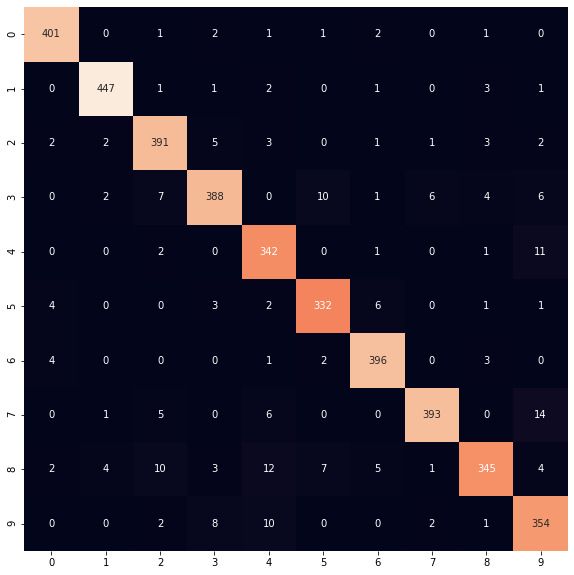

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       409
           1       0.98      0.98      0.98       456
           2       0.93      0.95      0.94       410
           3       0.95      0.92      0.93       424
           4       0.90      0.96      0.93       357
           5       0.94      0.95      0.95       349
           6       0.96      0.98      0.97       406
           7       0.98      0.94      0.96       419
           8       0.95      0.88      0.91       393
           9       0.90      0.94      0.92       377

    accuracy                           0.95      4000
   macro avg       0.95      0.95      0.95      4000
weighted avg       0.95      0.95      0.95      4000



In [63]:
rfc =  RandomForestClassifier(**grid.best_params_)
rfc = rfc.fit(train_in[:6000],train_lb[:6000])

pred_labels = rfc.predict(train_in[6000:10000])

mask = pred_labels==train_lb[6000:10000]
correct = np.count_nonzero(mask)
print(correct*100.0/pred_labels.size)

cm = confusion_matrix(train_lb[6000:10000], pred_labels)
fig = plt.figure(figsize = (10,10))
sns.heatmap(cm, annot = True, square = True, fmt = 'd', cbar = False)
plt.show()
print(classification_report(train_lb[6000:10000], pred_labels))

## Sieci:

In [64]:
network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(784,)))
network.add(layers.Dense(10, activation='softmax'))

In [65]:
network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [66]:
encoded_train_labels = to_categorical(train_lb)

In [67]:
network.fit(train_in[:6000], encoded_train_labels[:6000], epochs=5, batch_size=128)

Epoch 1/5
47/47 [==============================] - 0s 4ms/step - loss: 59.5893 - accuracy: 0.6595
Epoch 2/5
47/47 [==============================] - 0s 4ms/step - loss: 4.2964 - accuracy: 0.9201
Epoch 3/5
47/47 [==============================] - 0s 4ms/step - loss: 2.5959 - accuracy: 0.9399
Epoch 4/5
47/47 [==============================] - 0s 4ms/step - loss: 1.3126 - accuracy: 0.9604
Epoch 5/5
47/47 [==============================] - 0s 4ms/step - loss: 1.2127 - accuracy: 0.9626


In [68]:
test_loss, test_acc = network.evaluate(train_in[6000:10000], encoded_train_labels[6000:10000])
print('test_acc:', test_acc)

125/125 [==============================] - 0s 1ms/step - loss: 3.8985 - accuracy: 0.9147
test_acc: 0.9147499799728394


In [69]:
pred_probabilities = network.predict(train_in[6000:10000])
print(pred_probabilities[0:1])

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


In [70]:
pred_labels = np.argmax(pred_probabilities,-1)

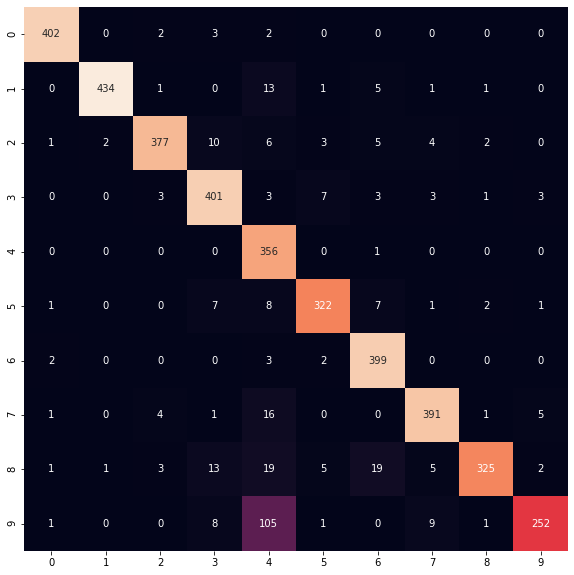

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       409
           1       0.99      0.95      0.97       456
           2       0.97      0.92      0.94       410
           3       0.91      0.95      0.93       424
           4       0.67      1.00      0.80       357
           5       0.94      0.92      0.93       349
           6       0.91      0.98      0.94       406
           7       0.94      0.93      0.94       419
           8       0.98      0.83      0.90       393
           9       0.96      0.67      0.79       377

    accuracy                           0.91      4000
   macro avg       0.93      0.91      0.91      4000
weighted avg       0.93      0.91      0.92      4000



In [71]:
cm = confusion_matrix(train_lb[6000:10000], pred_labels)
fig = plt.figure(figsize = (10,10))
sns.heatmap(cm, annot = True, square = True, fmt = 'd', cbar = False)
plt.show()
print(classification_report(train_lb[6000:10000], pred_labels))

# Zadanie 4

# Trening klasyfikatorów dla zmieszanych danych
Wraz z wyborem parametrów modelu przy użyciu gridSearchCV.

In [72]:
train_deskewed = [deskew(im) for im in train_images]
train_deskewed = np.asarray(train_deskewed)

for i in train_deskewed:
    np.random.shuffle(i)

In [73]:
train_in = train_deskewed.reshape(-1,28*28)
train_lb = train_labels.reshape(-1,)
train_in.shape

(60000, 784)

## SVM

In [76]:
parameters = {'kernel':('linear','rbf'), 'C':(10,15,20), 'gamma':('scale', 'auto')}

svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=5, verbose=4)

clf.fit(train_in[:6000], train_lb[:6000])

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ...............C=10, gamma=scale, kernel=linear; total time=  15.4s
[CV 2/5] END ...............C=10, gamma=scale, kernel=linear; total time=  14.5s
[CV 3/5] END ...............C=10, gamma=scale, kernel=linear; total time=  14.3s
[CV 4/5] END ...............C=10, gamma=scale, kernel=linear; total time=  14.9s
[CV 5/5] END ...............C=10, gamma=scale, kernel=linear; total time=  14.6s
[CV 1/5] END ..................C=10, gamma=scale, kernel=rbf; total time=  17.8s
[CV 2/5] END ..................C=10, gamma=scale, kernel=rbf; total time=  17.7s
[CV 3/5] END ..................C=10, gamma=scale, kernel=rbf; total time=  17.8s
[CV 4/5] END ..................C=10, gamma=scale, kernel=rbf; total time=  17.7s
[CV 5/5] END ..................C=10, gamma=scale, kernel=rbf; total time=  17.7s
[CV 1/5] END ................C=10, gamma=auto, kernel=linear; total time=  15.0s
[CV 2/5] END ................C=10, gamma=auto, k

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': (10, 15, 20), 'gamma': ('scale', 'auto'),
                         'kernel': ('linear', 'rbf')},
             verbose=4)

In [77]:
clf.best_score_, clf.best_params_

(0.5993333333333333, {'C': 15, 'gamma': 'scale', 'kernel': 'rbf'})

60.75


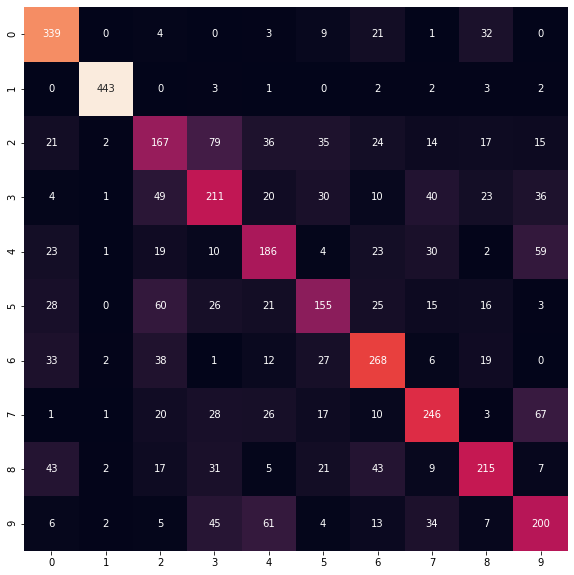

              precision    recall  f1-score   support

           0       0.68      0.83      0.75       409
           1       0.98      0.97      0.97       456
           2       0.44      0.41      0.42       410
           3       0.49      0.50      0.49       424
           4       0.50      0.52      0.51       357
           5       0.51      0.44      0.48       349
           6       0.61      0.66      0.63       406
           7       0.62      0.59      0.60       419
           8       0.64      0.55      0.59       393
           9       0.51      0.53      0.52       377

    accuracy                           0.61      4000
   macro avg       0.60      0.60      0.60      4000
weighted avg       0.61      0.61      0.60      4000



In [78]:
model = svm.SVC(**clf.best_params_)
model.fit(train_in[:6000], train_lb[:6000])
pred_labels = model.predict(train_in[6000:10000].reshape(-1, 28*28))
real_labels = train_lb[6000:10000]

mask = pred_labels == real_labels
correct = np.count_nonzero(mask)
print(correct*100.0/pred_labels.size)

cm = confusion_matrix(real_labels, pred_labels)
fig = plt.figure(figsize = (10,10))
sns.heatmap(cm, annot = True, square = True, fmt = 'd', cbar = False)
plt.show()
print(classification_report(real_labels, pred_labels))

## Random Forest Classifier ##

In [79]:
params = {'max_features': [1,30,60],
          'max_depth': [15,20,25], 
          'criterion': ["entropy","gini"]}
model = RandomForestClassifier()

grid=GridSearchCV(estimator=model, param_grid=params, cv=5, verbose = 4)
grid.fit(train_in[:6000],train_lb[:6000])

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END criterion=entropy, max_depth=15, max_features=1; total time=   0.6s
[CV 2/5] END criterion=entropy, max_depth=15, max_features=1; total time=   0.6s
[CV 3/5] END criterion=entropy, max_depth=15, max_features=1; total time=   0.6s
[CV 4/5] END criterion=entropy, max_depth=15, max_features=1; total time=   0.6s
[CV 5/5] END criterion=entropy, max_depth=15, max_features=1; total time=   0.7s
[CV 1/5] END criterion=entropy, max_depth=15, max_features=30; total time=   4.7s
[CV 2/5] END criterion=entropy, max_depth=15, max_features=30; total time=   4.7s
[CV 3/5] END criterion=entropy, max_depth=15, max_features=30; total time=   4.5s
[CV 4/5] END criterion=entropy, max_depth=15, max_features=30; total time=   4.5s
[CV 5/5] END criterion=entropy, max_depth=15, max_features=30; total time=   4.5s
[CV 1/5] END criterion=entropy, max_depth=15, max_features=60; total time=   8.3s
[CV 2/5] END criterion=entropy, max_depth=

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [15, 20, 25],
                         'max_features': [1, 30, 60]},
             verbose=4)

In [80]:
grid.best_score_, grid.best_params_

(0.49800000000000005,
 {'criterion': 'gini', 'max_depth': 15, 'max_features': 60})

51.275


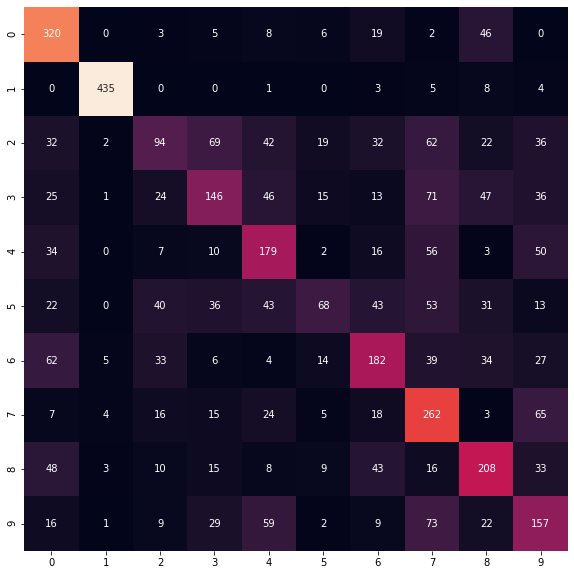

              precision    recall  f1-score   support

           0       0.57      0.78      0.66       409
           1       0.96      0.95      0.96       456
           2       0.40      0.23      0.29       410
           3       0.44      0.34      0.39       424
           4       0.43      0.50      0.46       357
           5       0.49      0.19      0.28       349
           6       0.48      0.45      0.46       406
           7       0.41      0.63      0.50       419
           8       0.49      0.53      0.51       393
           9       0.37      0.42      0.39       377

    accuracy                           0.51      4000
   macro avg       0.50      0.50      0.49      4000
weighted avg       0.51      0.51      0.50      4000



In [81]:
rfc =  RandomForestClassifier(**grid.best_params_)
rfc = rfc.fit(train_in[:6000],train_lb[:6000])

pred_labels = rfc.predict(train_in[6000:10000])

mask = pred_labels==train_lb[6000:10000]
correct = np.count_nonzero(mask)
print(correct*100.0/pred_labels.size)

cm = confusion_matrix(train_lb[6000:10000], pred_labels)
fig = plt.figure(figsize = (10,10))
sns.heatmap(cm, annot = True, square = True, fmt = 'd', cbar = False)
plt.show()
print(classification_report(train_lb[6000:10000], pred_labels))

## Sieci ##

In [82]:
network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(784,)))
network.add(layers.Dense(10, activation='softmax'))

In [83]:
network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [84]:
encoded_train_labels = to_categorical(train_lb)

In [85]:
network.fit(train_in[:6000], encoded_train_labels[:6000], epochs=5, batch_size=128)

Epoch 1/5
47/47 [==============================] - 1s 6ms/step - loss: 114.4156 - accuracy: 0.2655
Epoch 2/5
47/47 [==============================] - 0s 6ms/step - loss: 14.5928 - accuracy: 0.4814
Epoch 3/5
47/47 [==============================] - 0s 6ms/step - loss: 4.8641 - accuracy: 0.6067
Epoch 4/5
47/47 [==============================] - 0s 5ms/step - loss: 2.0907 - accuracy: 0.7150
Epoch 5/5
47/47 [==============================] - 0s 5ms/step - loss: 1.2729 - accuracy: 0.7993


In [86]:
test_loss, test_acc = network.evaluate(train_in[6000:10000], encoded_train_labels[6000:10000])
print('test_acc:', test_acc)

125/125 [==============================] - 0s 2ms/step - loss: 8.5844 - accuracy: 0.4345
test_acc: 0.4345000088214874


In [87]:
pred_probabilities = network.predict(train_in[6000:10000])
print(pred_probabilities[0:1])

[[9.99995708e-01 4.82480073e-20 3.43158879e-09 2.11136303e-10
  7.52903295e-10 4.35467378e-08 1.20024518e-10 4.21043452e-12
  4.25110966e-06 1.19826405e-14]]


In [88]:
pred_labels = np.argmax(pred_probabilities,-1)

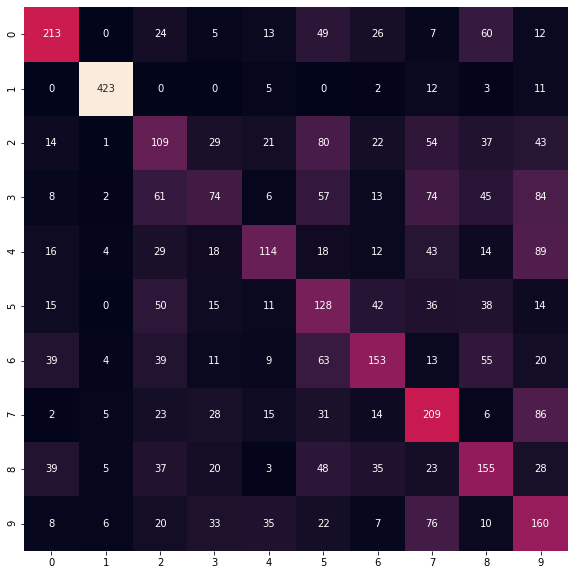

              precision    recall  f1-score   support

           0       0.60      0.52      0.56       409
           1       0.94      0.93      0.93       456
           2       0.28      0.27      0.27       410
           3       0.32      0.17      0.23       424
           4       0.49      0.32      0.39       357
           5       0.26      0.37      0.30       349
           6       0.47      0.38      0.42       406
           7       0.38      0.50      0.43       419
           8       0.37      0.39      0.38       393
           9       0.29      0.42      0.35       377

    accuracy                           0.43      4000
   macro avg       0.44      0.43      0.43      4000
weighted avg       0.45      0.43      0.43      4000



In [89]:
cm = confusion_matrix(train_lb[6000:10000], pred_labels)
fig = plt.figure(figsize = (10,10))
sns.heatmap(cm, annot = True, square = True, fmt = 'd', cbar = False)
plt.show()

print(classification_report(train_lb[6000:10000], pred_labels))

# Wnioski

### Porównanie wynika działania klasyfikatorów, trenowanymi obrazami oryginalnymi oraz obrazami po zadziałaniu funkcji Deskew:

Z deskew:  
SVM: 97%  
Random Forest: 93%  
Sieci: 92%  

Bez deskew:  
SVM: 95%  
Random Forest: 93%  
Sieci: 92%  

#### Zauważalne są niewielkie różnice, ale jednak dla wszystkich klasyfikatorów funkcja Deskew pomaga w nauce

### Porównanie wyniku działania klasyfikatorów, trenowanymi obrazami oryginalnymi oraz danymi po zadziałaniu funkcji OpenCVHOG:

Z HOG:  
SVM: 97%  
Random Forest: 93%  
Sieci: 92%  

Bez HOG: 
SVM: 97%  
Random Forest: 95%  
Sieci: 91%  

#### W przypadku klasyfikatora SVM, nie zauważono znacznych różnic, niewielkie różnice pojawiły się przy Random Forest (tutaj dla danych bez funkcji HOG klasyfikator poradzil sobie nieco lepiej) oraz dla Sieci (w tym przypadku dla danych z funkcją HOG poradził sobie lepiej)

### Porównanie wyniku działania klasyfikatorów, trenowanymi obrazami oryginalnymi oraz danymi "zmieszanymi":

Niezmieszane:  
SVM: 97%  
Random Forest: 95%  
Sieci: 91%  

Zmieszane:
SVM: 61%  
Random Forest: 51%  
Sieci: 43%  

#### Tutaj zauważalne są największe różnice, czego można się było spodziewać, ale ciekawe jest to, że mimo zmieszanych danych klasyfikatory oraz sieć w całkiem dobrym stopniu się uczą. 